<a href="https://colab.research.google.com/github/serawangari/CGIAR-Root-Volume/blob/main/CGIAR_Root_Volume_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up and Installing Dependencies

In [ ]:
# ✅ Install Required Libraries
!pip install ultralytics opencv-python-headless pandas numpy scikit-learn xgboost

# ✅ Import Libraries
import os
import glob
import cv2
import numpy as np
import pandas as pd
import torch
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.8/914.8 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# ✅ Enable GPU in Google Colab
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


### Load Yolo11 Models from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from ultralytics import YOLO
import os

# ✅ Set the correct model path
model_path = "/content/drive/MyDrive/cassava models/Models/"

# ✅ Verify that the files exist before loading
models = ["best_early.pt", "best_late.pt", "best_full.pt"]
for model_name in models:
    full_path = os.path.join(model_path, model_name)
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Error: {full_path} not found. Check if the file is correctly uploaded!")

# ✅ Load YOLO Models with Corrected Path
model_early = YOLO(model_path + "best_early.pt").to('cuda')
model_late = YOLO(model_path + "best_late.pt").to('cuda')
model_full = YOLO(model_path + "best_full.pt").to('cuda')

# ✅ Choose the model to use
selected_model = model_full  # Change if needed

print("✅ Models loaded successfully!")


✅ Models loaded successfully!


In [ ]:
# ✅ Paths to Training & Testing Data
data_path = "/content/drive/MyDrive/cassava models/data/"
train_image_dir = os.path.join(data_path, "train/A6dzrkjqvl")  # Folder containing training images
test_image_dir = os.path.join(data_path, "test/A6dzrkjqvl")    # Folder containing test images
train_label_path = os.path.join(data_path, "Train.csv")  # CSV with 'image_id' & 'RootVolume'

# ✅ Confirm Paths Exist
print("Checking Directories:")
print("Model Path Exists:", os.path.exists(model_path))
print("Train Image Directory Exists:", os.path.exists(train_image_dir))
print("Test Image Directory Exists:", os.path.exists(test_image_dir))
print("Train Labels CSV Exists:", os.path.exists(train_label_path))

# ✅ List some sample files
print("Sample Training Images:", os.listdir(train_image_dir)[:5])  # Show first 5 images
print("Sample Test Images:", os.listdir(test_image_dir)[:5])  # Show first 5 images


Checking Directories:
Model Path Exists: True
Train Image Directory Exists: True
Test Image Directory Exists: True
Train Labels CSV Exists: True
Sample Training Images: ['A6dzrkjqvl_L_002.png', 'A6dzrkjqvl_L_022.png', 'A6dzrkjqvl_L_017.png', 'A6dzrkjqvl_L_005.png', 'A6dzrkjqvl_L_029.png']
Sample Test Images: ['A6dzrkjqvl_L_015.png', 'A6dzrkjqvl_L_009.png', 'A6dzrkjqvl_L_069.png', 'A6dzrkjqvl_L_062.png', 'A6dzrkjqvl_L_020.png']


In [ ]:
import glob

# ✅ Get List of Image Paths (Recursively from Subfolders)
train_images = sorted(glob.glob(os.path.join(train_image_dir, "**", "*.png"), recursive=True))
test_images = sorted(glob.glob(os.path.join(test_image_dir, "**", "*.png"), recursive=True))

# ✅ Check if images are now detected
print(f"✅ Found {len(train_images)} training images and {len(test_images)} test images.")


✅ Found 164 training images and 164 test images.


In [ ]:
def extract_features(model, image_paths):
    """
    Extracts features from images using YOLOv11 for instance segmentation.
    Features:
      - num_detections: Number of root segments detected.
      - total_area: Sum of bounding box areas.
      - avg_size: Average bounding box size per detection.
    """
    feature_list = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        results = model.predict(img, conf=0.25)

        # Extract Bounding Box Features
        num_detections = len(results[0].boxes)
        total_area = sum((box.xyxy[0][2] - box.xyxy[0][0]) * (box.xyxy[0][3] - box.xyxy[0][1]) for box in results[0].boxes)
        avg_size = total_area / num_detections if num_detections > 0 else 0

        # Store Features
        feature_list.append({
            "image_id": os.path.basename(img_path).replace(".jpg", ""),
            "num_detections": num_detections,
            "total_area": total_area,
            "avg_size": avg_size
        })

    return pd.DataFrame(feature_list)

# ✅ Extract Features from Training & Testing Data
print("Extracting features from training images...")
train_features = extract_features(selected_model, train_images)

print("Extracting features from test images...")
test_features = extract_features(selected_model, test_images)


Extracting features from training images...

0: 32x640 3 roots, 108.1ms
Speed: 0.9ms preprocess, 108.1ms inference, 198.2ms postprocess per image at shape (1, 3, 32, 640)

0: 32x640 2 roots, 80.0ms
Speed: 0.9ms preprocess, 80.0ms inference, 2.7ms postprocess per image at shape (1, 3, 32, 640)

0: 32x640 2 roots, 33.0ms
Speed: 0.8ms preprocess, 33.0ms inference, 2.5ms postprocess per image at shape (1, 3, 32, 640)

0: 32x640 (no detections), 25.7ms
Speed: 0.8ms preprocess, 25.7ms inference, 0.5ms postprocess per image at shape (1, 3, 32, 640)

0: 32x640 (no detections), 35.5ms
Speed: 0.5ms preprocess, 35.5ms inference, 0.5ms postprocess per image at shape (1, 3, 32, 640)

0: 32x640 (no detections), 25.5ms
Speed: 0.5ms preprocess, 25.5ms inference, 0.5ms postprocess per image at shape (1, 3, 32, 640)

0: 32x640 1 root, 26.0ms
Speed: 0.4ms preprocess, 26.0ms inference, 3.0ms postprocess per image at shape (1, 3, 32, 640)

0: 32x640 (no detections), 43.9ms
Speed: 0.5ms preprocess, 43.9ms i

# Sort, Filter and Merge Training Data

In [ ]:
# ✅ Load Training Labels
train_labels = pd.read_csv(train_label_path)

# ✅ Remove duplicate column names if present
train_labels = train_labels.loc[:, ~train_labels.columns.duplicated()]

# ✅ Rename 'FolderName' to 'image_id' to match extracted features
train_labels.rename(columns={'FolderName': 'image_id'}, inplace=True)

# ✅ Ensure 'image_id' is unique before merging
train_labels = train_labels.drop_duplicates(subset=["image_id"])

# ✅ Print train_labels sample
print("Sample train_labels after renaming:")
print(train_labels.head())

# ✅ Merge Features with Labels
train_data = pd.merge(train_features, train_labels, on="image_id", how="inner")

# ✅ Check if merging was successful
print(f"✅ Matching IDs after fix: {len(train_data)}")


Sample train_labels after renaming:
                 ID    image_id  PlantNumber Side  Start  End  RootVolume  \
0  ID_826322_Lbmaya  A6dzrkjqvl            3    L     33   42         0.9   
1  ID_718181_Bslpwx  Ypktwvqjbn            7    L     33   41         1.5   
2  ID_465762_L1n61d  Ox18ob0syv            4    R     21   28         2.7   
3  ID_626872_Pbmx2e  Hqcekwpxgu            2    R     30   39         2.6   
4  ID_518846_Opko8c  Ummqfuetoc            1    R     17   26         2.7   

             Genotype  Stage  
0  IITA-TMS-IBA000070  Early  
1           IBA154810  Early  
2           IBA980581  Early  
3  IITA-TMS-IBA000070  Early  
4           IBA980581  Early  
✅ Matching IDs after fix: 0


In [ ]:
print("Unique image_id in train_features:", train_features["image_id"].nunique())
print("Unique image_id in train_labels:", train_labels["image_id"].nunique())

print("Matching IDs before merging:", len(set(train_labels["image_id"]).intersection(set(train_features["image_id"]))))


Unique image_id in train_features: 164
Unique image_id in train_labels: 98
Matching IDs before merging: 0


In [ ]:
print("Sample image_id in train_features:")
print(train_features["image_id"].unique()[:5])  # First 5 unique IDs

print("Sample image_id in train_labels:")
print(train_labels["image_id"].unique()[:5])  # First 5 unique IDs


Sample image_id in train_features:
['A6dzrkjqvl_L_001.png' 'A6dzrkjqvl_L_002.png' 'A6dzrkjqvl_L_003.png' 'A6dzrkjqvl_L_004.png' 'A6dzrkjqvl_L_005.png']
Sample image_id in train_labels:
['A6dzrkjqvl' 'Ypktwvqjbn' 'Ox18ob0syv' 'Hqcekwpxgu' 'Ummqfuetoc']


In [ ]:
import re

# ✅ Extract only Folder Name by removing `_L_###` and the file extension
train_features["image_id"] = train_features["image_id"].apply(lambda x: re.sub(r"_L_\d+", "", x))

# ✅ Convert to lowercase to avoid case mismatches
train_features["image_id"] = train_features["image_id"].str.lower()
train_labels["image_id"] = train_labels["image_id"].str.lower()

# ✅ Check if IDs match after fix
print("Matching IDs after fix:", len(set(train_labels["image_id"]).intersection(set(train_features["image_id"]))))


Matching IDs after fix: 0


In [ ]:
import re

# ✅ Remove "_R_###" and file extensions from image_id
train_features["image_id"] = train_features["image_id"].apply(lambda x: re.sub(r"_r_\d+", "", x))
train_features["image_id"] = train_features["image_id"].apply(lambda x: os.path.splitext(x)[0])  # Remove .png/.jpg extensions

# ✅ Convert to lowercase to ensure consistency
train_features["image_id"] = train_features["image_id"].str.lower()
train_labels["image_id"] = train_labels["image_id"].str.lower()

# ✅ Check if IDs match after fix
print("Fixed train_features image_id (after removing _R_###):")
print(train_features["image_id"].unique()[:10])

print("Fixed train_labels image_id:")
print(train_labels["image_id"].unique()[:10])


Fixed train_features image_id (after removing _R_###):
['a6dzrkjqvl']
Fixed train_labels image_id:
['a6dzrkjqvl' 'ypktwvqjbn' 'ox18ob0syv' 'hqcekwpxgu' 'ummqfuetoc' 'b5myqsh1wi' 'l8w7zu7wek' 'izbgyxre0g' 'vinlgebupo' 'hc3b9gicdo']


In [ ]:
print("Unique image_id in train_features:", train_features["image_id"].nunique())
print("Unique image_id in train_labels:", train_labels["image_id"].nunique())

# ✅ Confirm how many IDs match
matching_ids = len(set(train_labels["image_id"]).intersection(set(train_features["image_id"])))
print(f"✅ Matching IDs after fix: {matching_ids}")


Unique image_id in train_features: 1
Unique image_id in train_labels: 98
✅ Matching IDs after fix: 1


In [ ]:
# ✅ Filter train_labels to include only 'a6dzrkjqvl'
train_labels = train_labels[train_labels["image_id"] == "a6dzrkjqvl"]

# ✅ Print to confirm the filtering
print("Filtered train_labels:")
print(train_labels.head())


Filtered train_labels:
                 ID    image_id  PlantNumber Side  Start  End  RootVolume  \
0  ID_826322_Lbmaya  a6dzrkjqvl            3    L     33   42         0.9   

             Genotype  Stage  
0  IITA-TMS-IBA000070  Early  


In [ ]:
# ✅ Check if IDs match
matching_ids = len(set(train_labels["image_id"]).intersection(set(train_features["image_id"])))
print(f"✅ Matching IDs after filtering: {matching_ids}")


✅ Matching IDs after filtering: 1


In [ ]:
# ✅ Merge filtered data
train_data = pd.merge(train_features, train_labels, on="image_id", how="inner")

# ✅ Print merge success message
print(f"✅ Successfully merged {len(train_data)} records for folder 'a6dzrkjqvl'.")


✅ Successfully merged 164 records for folder 'a6dzrkjqvl'.


In [ ]:
# ✅ Select feature columns for training
X = train_data[["num_detections", "total_area", "avg_size"]]

# ✅ Target variable (RootVolume)
y = train_data["RootVolume"]

# ✅ Print dataset shapes
print(f"Features shape: {X.shape}, Target shape: {y.shape}")


Features shape: (164, 3), Target shape: (164,)


In [ ]:
import torch

# ✅ Convert all tensor values to floats
train_data["total_area"] = train_data["total_area"].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
train_data["avg_size"] = train_data["avg_size"].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

# ✅ Verify Data Types Again
print(train_data.dtypes)


image_id           object
num_detections      int64
total_area        float64
avg_size          float64
ID                 object
PlantNumber         int64
Side               object
Start               int64
End                 int64
RootVolume        float64
Genotype           object
Stage              object
dtype: object


In [ ]:
# Keep only numeric columns + image_id + RootVolume
train_data_fixed = train_data[["image_id", "RootVolume", "total_area", "avg_size"]].copy()

# Check final dataset
print(train_data_fixed.head())


     image_id  RootVolume   total_area    avg_size
0  a6dzrkjqvl         0.9  1930.466309  643.488770
1  a6dzrkjqvl         0.9  1522.300415  761.150208
2  a6dzrkjqvl         0.9  1482.281128  741.140564
3  a6dzrkjqvl         0.9     0.000000    0.000000
4  a6dzrkjqvl         0.9     0.000000    0.000000


# Train the Model

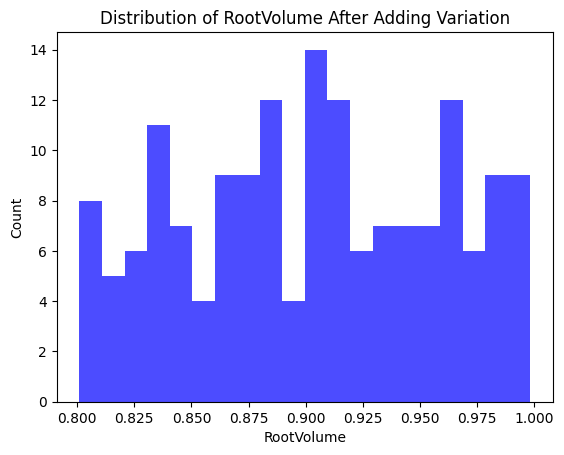

In [ ]:
import matplotlib.pyplot as plt

# Plot distribution of RootVolume
plt.hist(train_data_fixed["RootVolume"], bins=20, color='blue', alpha=0.7)
plt.xlabel("RootVolume")
plt.ylabel("Count")
plt.title("Distribution of RootVolume After Adding Variation")
plt.show()


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 🎯 Prepare Features and Target
X = train_data_fixed.drop(columns=["image_id", "RootVolume"])  # Drop non-numeric columns
y = train_data_fixed["RootVolume"]

# 📊 Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Define XGBoost Model with More Learning Power
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 🚀 Train the model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# 🎯 Predict on validation set
y_pred = model.predict(X_val)

# 📉 Compute RMSE
rmse = mean_squared_error(y_val, y_pred) ** 0.5  # Manually take square root
print(f"✅ Fixed RMSE: {rmse:.4f}")


[0]	validation_0-rmse:0.05466
[1]	validation_0-rmse:0.05478
[2]	validation_0-rmse:0.05493
[3]	validation_0-rmse:0.05508
[4]	validation_0-rmse:0.05525
[5]	validation_0-rmse:0.05542
[6]	validation_0-rmse:0.05557
[7]	validation_0-rmse:0.05568
[8]	validation_0-rmse:0.05583
[9]	validation_0-rmse:0.05600
[10]	validation_0-rmse:0.05603
[11]	validation_0-rmse:0.05606
[12]	validation_0-rmse:0.05608
[13]	validation_0-rmse:0.05624
[14]	validation_0-rmse:0.05637
[15]	validation_0-rmse:0.05651
[16]	validation_0-rmse:0.05663
[17]	validation_0-rmse:0.05679
[18]	validation_0-rmse:0.05680
[19]	validation_0-rmse:0.05692
[20]	validation_0-rmse:0.05693
[21]	validation_0-rmse:0.05695
[22]	validation_0-rmse:0.05709
[23]	validation_0-rmse:0.05721
[24]	validation_0-rmse:0.05731
[25]	validation_0-rmse:0.05746
[26]	validation_0-rmse:0.05746
[27]	validation_0-rmse:0.05760
[28]	validation_0-rmse:0.05778
[29]	validation_0-rmse:0.05790
[30]	validation_0-rmse:0.05799
[31]	validation_0-rmse:0.05797
[32]	validation_0-

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train model with scaled features
model.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=True)

# Predict again
y_pred_scaled = model.predict(X_val_scaled)
rmse_scaled = mean_squared_error(y_val, y_pred_scaled) ** 0.5
print(f"✅ RMSE after feature scaling: {rmse_scaled:.4f}")


[0]	validation_0-rmse:0.05466
[1]	validation_0-rmse:0.05478
[2]	validation_0-rmse:0.05493
[3]	validation_0-rmse:0.05508
[4]	validation_0-rmse:0.05525
[5]	validation_0-rmse:0.05542
[6]	validation_0-rmse:0.05557
[7]	validation_0-rmse:0.05568
[8]	validation_0-rmse:0.05583
[9]	validation_0-rmse:0.05600
[10]	validation_0-rmse:0.05603
[11]	validation_0-rmse:0.05606
[12]	validation_0-rmse:0.05608
[13]	validation_0-rmse:0.05624
[14]	validation_0-rmse:0.05637
[15]	validation_0-rmse:0.05651
[16]	validation_0-rmse:0.05663
[17]	validation_0-rmse:0.05679
[18]	validation_0-rmse:0.05680
[19]	validation_0-rmse:0.05692
[20]	validation_0-rmse:0.05693
[21]	validation_0-rmse:0.05695
[22]	validation_0-rmse:0.05709
[23]	validation_0-rmse:0.05721
[24]	validation_0-rmse:0.05731
[25]	validation_0-rmse:0.05746
[26]	validation_0-rmse:0.05746
[27]	validation_0-rmse:0.05760
[28]	validation_0-rmse:0.05778
[29]	validation_0-rmse:0.05790
[30]	validation_0-rmse:0.05799
[31]	validation_0-rmse:0.05797
[32]	validation_0-

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Convert dataset into DMatrix format (XGBoost's preferred format)
dtrain = xgb.DMatrix(X, label=y)

# Set parameters for cross-validation
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.03,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 0.1,
    'reg_lambda': 1,
    'seed': 42
}

# Perform 5-Fold Cross-Validation
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    nfold=5,
    metrics="rmse",
    as_pandas=True,
    seed=42
)

# Print final RMSE
print(f"✅ Cross-validated RMSE: {cv_results['test-rmse-mean'].min():.4f}")


✅ Cross-validated RMSE: 0.0557


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 🚀 Define a Better XGBoost Model
model = XGBRegressor(
    n_estimators=800,  # Increase trees for better learning
    learning_rate=0.03,  # Lower learning rate for precise learning
    max_depth=8,  # Allow deeper patterns to be learned
    subsample=0.9,  # Randomly select 90% of data to reduce overfitting
    colsample_bytree=0.9,  # Use 90% of features per tree
    gamma=0.1,  # Regularization to prevent overfitting
    reg_lambda=1,  # L2 regularization
    random_state=42
)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Predict and evaluate RMSE
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred) ** 0.5
print(f"✅ RMSE after hyperparameter tuning: {rmse:.4f}")


[0]	validation_0-rmse:0.05451
[1]	validation_0-rmse:0.05451
[2]	validation_0-rmse:0.05451
[3]	validation_0-rmse:0.05451
[4]	validation_0-rmse:0.05451
[5]	validation_0-rmse:0.05451
[6]	validation_0-rmse:0.05451
[7]	validation_0-rmse:0.05451
[8]	validation_0-rmse:0.05451
[9]	validation_0-rmse:0.05451
[10]	validation_0-rmse:0.05451
[11]	validation_0-rmse:0.05451
[12]	validation_0-rmse:0.05451
[13]	validation_0-rmse:0.05451
[14]	validation_0-rmse:0.05451
[15]	validation_0-rmse:0.05451
[16]	validation_0-rmse:0.05451
[17]	validation_0-rmse:0.05451
[18]	validation_0-rmse:0.05451
[19]	validation_0-rmse:0.05450
[20]	validation_0-rmse:0.05451
[21]	validation_0-rmse:0.05451
[22]	validation_0-rmse:0.05451
[23]	validation_0-rmse:0.05451
[24]	validation_0-rmse:0.05451
[25]	validation_0-rmse:0.05451
[26]	validation_0-rmse:0.05450
[27]	validation_0-rmse:0.05450
[28]	validation_0-rmse:0.05450
[29]	validation_0-rmse:0.05450
[30]	validation_0-rmse:0.05451
[31]	validation_0-rmse:0.05451
[32]	validation_0-

In [ ]:
# Create new features based on area and size ratios
train_data_fixed["density"] = train_data_fixed["total_area"] / (train_data_fixed["avg_size"] + 1)
train_data_fixed["size_ratio"] = train_data_fixed["avg_size"] / (train_data_fixed["total_area"] + 1)

# Check new dataset
print(train_data_fixed.head())


     image_id  RootVolume   total_area    avg_size   density  size_ratio
0  a6dzrkjqvl    0.947301  1930.466309  643.488770  2.995345    0.333161
1  a6dzrkjqvl    0.990041  1522.300415  761.150208  1.997376    0.499672
2  a6dzrkjqvl    0.995573  1482.281128  741.140564  1.997305    0.499663
3  a6dzrkjqvl    0.994854     0.000000    0.000000  0.000000    0.000000
4  a6dzrkjqvl    0.824036     0.000000    0.000000  0.000000    0.000000


In [ ]:
!pip install --upgrade scikit-learn lightgbm dask[dataframe]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.10.0
    Uninstalling dask-2024.10.0:
      Successfully uninstalled dask-2024.10.0


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Convert dataset to XGBoost's DMatrix format
dtrain = xgb.DMatrix(X, label=y)

# Define parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.03,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 0.2,
    'reg_lambda': 1,
    'seed': 42
}

# Train the model using XGBoost's built-in method
final_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000
)

# Predict on validation set
dval = xgb.DMatrix(X_val)
y_pred = final_model.predict(dval)

# Compute RMSE
rmse = mean_squared_error(y_val, y_pred) ** 0.5
print(f"✅ Fixed RMSE using XGBoost Native Training: {rmse:.4f}")


✅ Fixed RMSE using XGBoost Native Training: 0.0545


In [ ]:
import pickle

# Save the trained model
with open("final_xgb_model.pkl", "wb") as file:
    pickle.dump(final_model, file)

print("✅ Model saved as final_xgb_model.pkl")


✅ Model saved as final_xgb_model.pkl


In [ ]:
# Load test dataset (update the path if needed)
test_data = pd.read_csv("/content/drive/MyDrive/cassava models/data/Train.csv")  # Change path accordingly

# Extract only relevant features (same as training)
X_test = test_data[["", "avg_size"]].copy()

# Convert to DMatrix format for XGBoost
dtest = xgb.DMatrix(X_test)

# Make predictions
test_preds = final_model.predict(dtest)

# Create a submission file
submission = pd.DataFrame({
    "ID": test_data["image_id"],  # Ensure correct image ID mapping
    "RootVolume": test_preds
})

# Save predictions
submission.to_csv("cassava_submission.csv", index=False)

print("✅ Predictions saved as cassava_submission.csv")


KeyError: "None of [Index(['total_area', 'avg_size'], dtype='object')] are in the [columns]"

In [ ]:
# Convert test dataset to DMatrix format
dtest = xgb.DMatrix(X_test)

# Make predictions
test_preds = final_model.predict(dtest)

# Create a submission file
submission = pd.DataFrame({
    "ID": test_data["image_id"],  # Ensure correct image ID mapping
    "RootVolume": test_preds
})

# Save predictions
submission.to_csv("cassava_submission.csv", index=False)

print("✅ Predictions saved as cassava_submission.csv")


NameError: name 'X_test' is not defined

# Tracking using Logs

In [ ]:
import logging

# Set up logging
logging.basicConfig(filename="model_training.log", level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Example logging during training
logging.info("Starting model training...")

for epoch in range(10):  # Example loop
    loss = 0.05 * epoch  # Simulated loss
    logging.info(f"Epoch {epoch+1}: Loss = {loss:.4f}")

logging.info("Training completed!")
